In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)

In [3]:
data_dir = '/opt/ml/input/data'
path_train = os.path.join(data_dir, 'train_data.csv')
path_test = os.path.join(data_dir, 'test_data.csv')

train_df = pd.read_csv(path_train, parse_dates=['Timestamp'])
test_df = pd.read_csv(path_test, parse_dates=['Timestamp'])

In [4]:
def columns_nunique(df, columns=None):
    if columns is None:
        for col in df.columns:
            print(f"Number of unique {col}: ", df[col].nunique())
    else:
        for col in columns:
            print(f"Number of unique {col}: ", df[col].nunique())

def missing_value(df):
    print(f"\nMissing vluae: \n{df.isnull().sum()}\n")

# 1. Train data 통계

In [5]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int64         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int64         
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 103.8+ MB


In [7]:
columns_nunique(train_df, columns=['userID', 'assessmentItemID', 'testId', 'KnowledgeTag'])
answer_code_ratio = train_df.answerCode.value_counts(normalize=True)
print(f'ratio of answerCode 0:1 = {answer_code_ratio[0]:.4f}:{answer_code_ratio[1]:.4f}')
missing_value(train_df)

Number of unique userID:  6698
Number of unique assessmentItemID:  9454
Number of unique testId:  1537
Number of unique KnowledgeTag:  912
ratio of answerCode 0:1 = 0.3456:0.6544

Missing vluae: 
userID              0
assessmentItemID    0
testId              0
answerCode          0
Timestamp           0
KnowledgeTag        0
dtype: int64



# 2. Train data EDA

In [8]:
def plot_joint(df, columns):
    print(f"{df.corr()[columns[0]][columns[1]]:.3f}")
    sns.jointplot(
        x=columns[0], y=columns[1],
        data=df,
        kind='reg',
        joint_kws = {'scatter_kws':dict(alpha=0.3), 'line_kws':dict(color='orange')},
        height=10
    ) 


def plot_hists(df, columns, title, labels):
    fig, ax = plt.subplots(1,1, figsize=(12, 7))

    ax.set_title(title)
    stu_num_mean = df[columns[0]].mean()
    df[df[columns[0]] >= stu_num_mean][columns[1]].hist(
        bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label=labels[0]
    )
    df[df[columns[0]] < stu_num_mean][columns[1]].hist(
        bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label=labels[1]
    )
    ax.legend()
    

percentile = lambda x : np.sum(x) / len(x)

## 2.1. user가 문제를 시도한 횟수에 따른 정답률

In [9]:
user_group = train_df.groupby('userID').agg({
    'assessmentItemID': 'count', # 유저가 시도한 문제 항목 수
    'answerCode': percentile,
})
user_group.rename(columns={'assessmentItemID': 'number_try_assessments', 'answerCode': 'answer_ratio'}, inplace=True)

In [10]:
user_group

,number_try_assessments,answer_ratio
userID,,
0,745,0.630872
1,933,0.853162
2,276,0.612319
5,833,0.795918
6,921,0.442997
...,...,...
7436,15,0.466667
7437,16,0.375000
7438,16,0.750000


In [11]:
user_group.describe()

,number_try_assessments,answer_ratio
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


User의 정답률과 user가 시도한 문제의 개수 사이 상관관계: 0.168


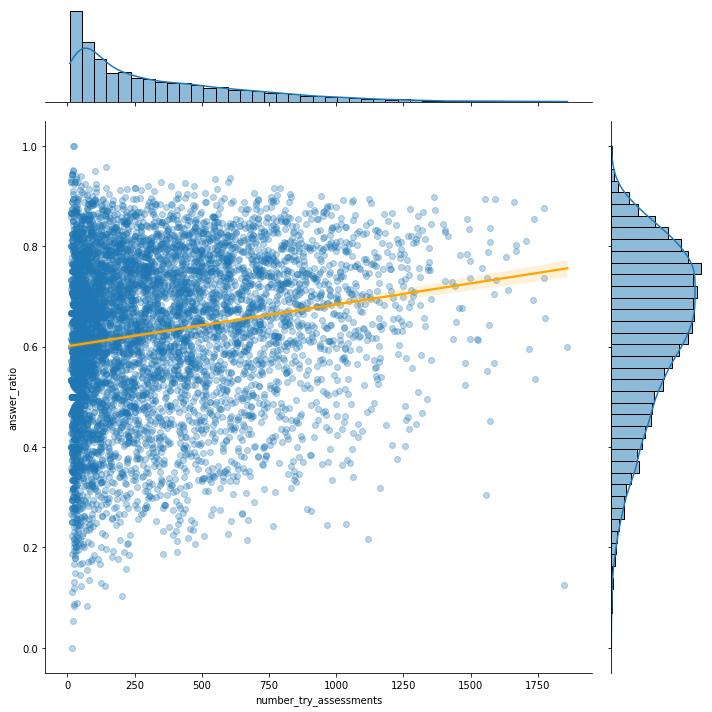

In [12]:
columns = ['number_try_assessments', 'answer_ratio']
print("User의 정답률과 user가 시도한 문제의 개수 사이 상관관계: ", end='')
plot_joint(user_group, columns)

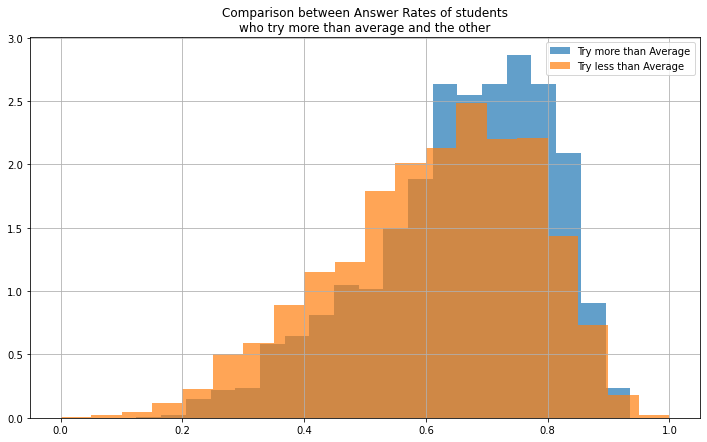

In [13]:
title = 'Comparison between Answer Rates of students\nwho try more than average and the other'
labels = ['Try more than Average', 'Try less than Average']

plot_hists(user_group, columns, title, labels )

## 2.2. 시도된 문제 항목의 개수에 따른 정답률

In [14]:
assessment_group = train_df.groupby('assessmentItemID').agg({
    'userID': 'count', # 해당 문제를 시도한 유저의 수
    'answerCode': percentile
})

assessment_group.rename(columns={'userID': 'number_tried_by_users', 'answerCode': 'answer_ratio'}, inplace=True)

In [15]:
assessment_group

,number_tried_by_users,answer_ratio
assessmentItemID,,
A010001001,317,0.930599
A010001002,317,0.958991
A010001003,317,0.905363
A010001004,317,0.949527
A010001005,317,0.886435
...,...,...
A090074002,45,0.444444
A090074003,45,0.577778
A090074004,45,0.333333


In [16]:
assessment_group.describe()

,number_tried_by_users,answer_ratio
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


문제 항목의 정답률과 문제 항목이 시도된 개수 사이 상관관계: 0.002


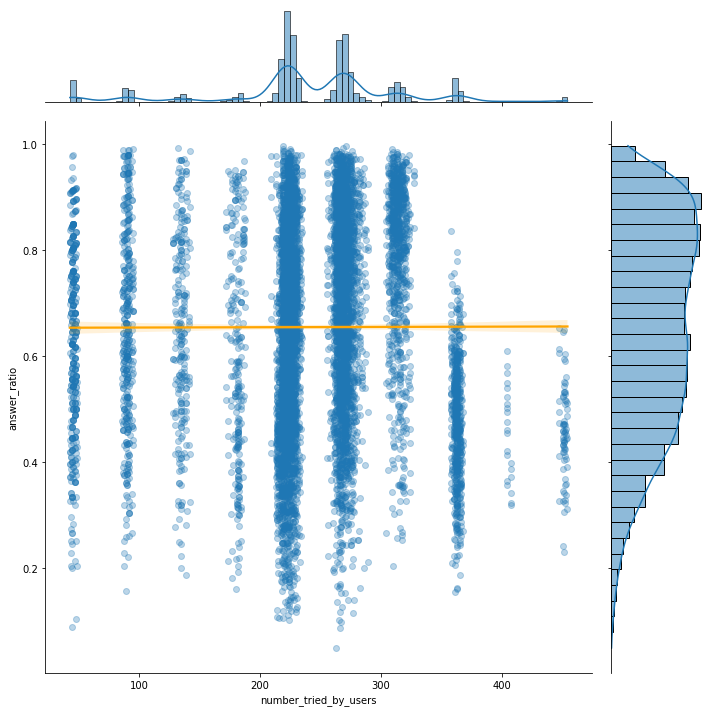

In [17]:
columns = ['number_tried_by_users', 'answer_ratio']
print("문제 항목의 정답률과 문제 항목이 시도된 개수 사이 상관관계: ", end='')
plot_joint(assessment_group, columns)

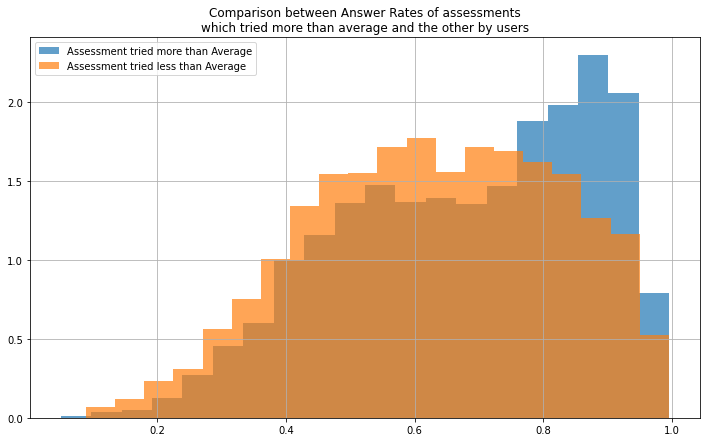

In [18]:
title = 'Comparison between Answer Rates of assessments\nwhich tried more than average and the other by users'
labels = ['Assessment tried more than Average', 'Assessment tried less than Average']

plot_hists(assessment_group, columns, title, labels )

## 2.3. 시도된 문제 tag의 수에 따른 정답률

In [19]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [20]:
tag_group = train_df.groupby('KnowledgeTag').agg({
    'userID': 'count', # 해당 Tag를 시도한 user의 수
    'answerCode': percentile,
})
tag_group.rename(columns={'userID': 'number_tried_by_users', 'answerCode': 'answer_ratio'}, inplace=True)

In [21]:
tag_group

,number_tried_by_users,answer_ratio
KnowledgeTag,,
23,1800,0.584444
24,358,0.614525
25,92,0.858696
26,2432,0.614309
30,539,0.536178
...,...,...
11253,4282,0.739374
11265,454,0.676211
11269,2417,0.557716


In [22]:
tag_group.describe()

,number_tried_by_users,answer_ratio
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


문제 Tag의 정답률과 문제 Tag가 시도된 개수 사이 상관관계: 0.376


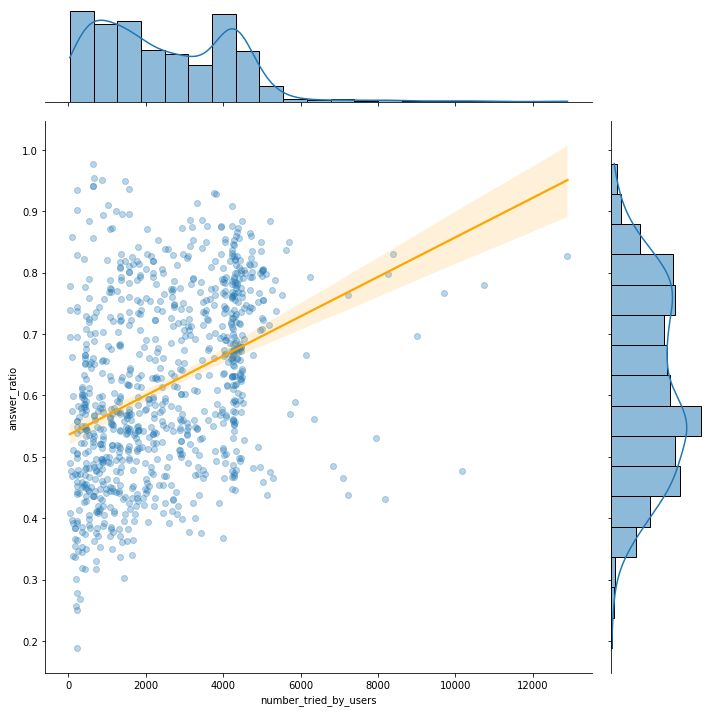

In [23]:
columns=['number_tried_by_users', 'answer_ratio']
print("문제 Tag의 정답률과 문제 Tag가 시도된 개수 사이 상관관계: ", end='')
plot_joint(tag_group, columns)

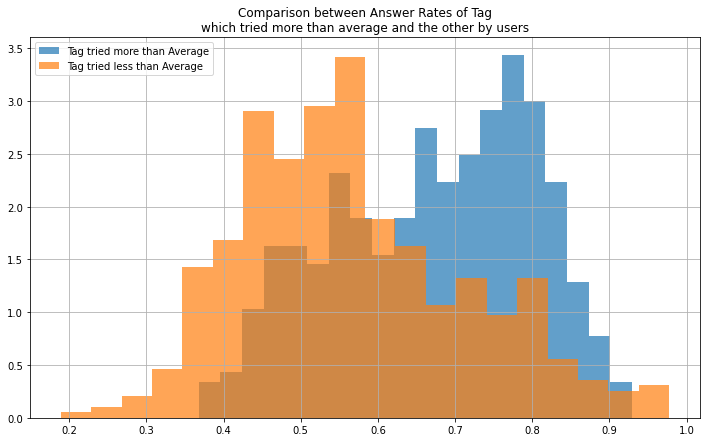

In [24]:
title = 'Comparison between Answer Rates of Tag\nwhich tried more than average and the other by users'
labels = ['Tag tried more than Average', 'Tag tried less than Average']
plot_hists(tag_group, columns, title, labels)

## 2.4. 시도된 시험지의 수에 따른 정답률

In [25]:
paper_group = train_df.groupby('testId').agg({
    'userID': 'count', # 해당 Tag를 시도한 user의 수
    'answerCode': percentile,
})
paper_group.rename(columns={'userID': 'number_tried_by_users', 'answerCode': 'answer_ratio'}, inplace=True)

In [26]:
paper_group

,number_tried_by_users,answer_ratio
testId,,
A010000001,1585,0.926183
A010000002,1550,0.931613
A010000003,1615,0.846440
A010000004,1540,0.883117
A010000005,1595,0.855172
...,...,...
A090000070,344,0.418605
A090000071,360,0.336111
A090000072,270,0.418519


In [27]:
paper_group.describe()

,number_tried_by_users,answer_ratio
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


시험지의 정답률과 문제 시험지가 시도된 개수 사이 상관관계: -0.271


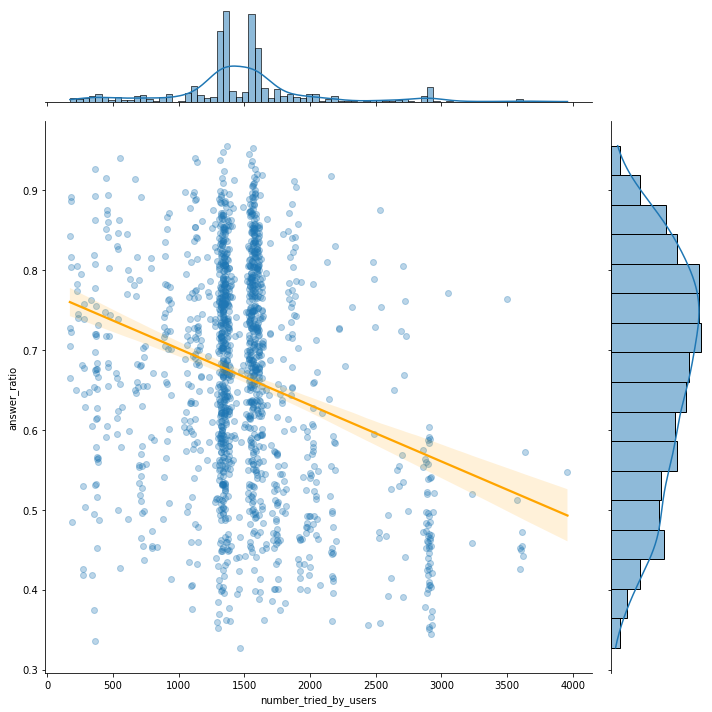

In [28]:
columns=['number_tried_by_users', 'answer_ratio']
print("시험지의 정답률과 문제 시험지가 시도된 개수 사이 상관관계: ", end='')
plot_joint(paper_group, columns)

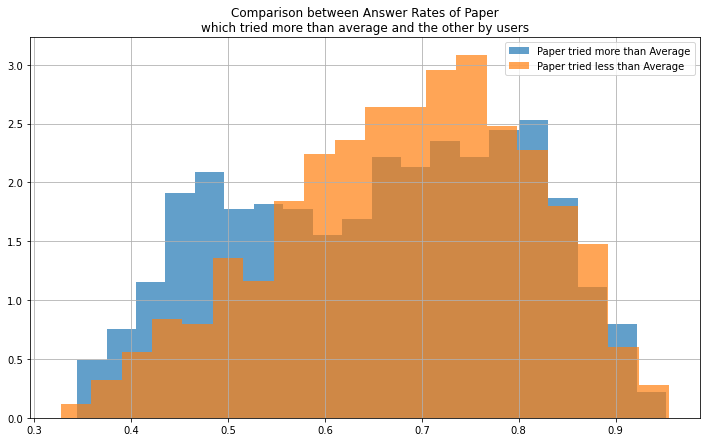

In [29]:
title = 'Comparison between Answer Rates of Paper\nwhich tried more than average and the other by users'
labels = ['Paper tried more than Average', 'Paper tried less than Average']
plot_hists(paper_group, columns, title, labels)

# 3. Timestamp

In [30]:
time_df = train_df.copy()

time_df['year'] = time_df['Timestamp'].dt.year
time_df['month'] = time_df['Timestamp'].dt.month
time_df['day'] = time_df['Timestamp'].dt.day
time_df['hour'] = time_df['Timestamp'].dt.hour

In [31]:
hour_group = time_df.groupby(['userID', 'hour']).agg({
    'answerCode': percentile,
}).reset_index()

hour_group.rename(columns={'answerCode': 'answer_ratio'}, inplace=True)

In [32]:
hour_group

,userID,hour,answer_ratio
0,0,0,0.652778
1,0,1,0.697561
2,0,2,0.590476
3,0,3,0.648352
4,0,4,0.631579
...,...,...,...
81621,7440,4,0.400000
81622,7440,8,0.200000
81623,7440,9,0.600000
81624,7441,1,1.000000


In [33]:
hour_group.describe()

,userID,hour,answer_ratio
count,81626.000000,81626.000000,81626.000000
mean,2982.068704,8.936038,0.642480
std,1929.629459,6.344357,0.259584
min,0.000000,0.000000,0.000000
25%,1340.000000,4.000000,0.484375
50%,2781.000000,8.000000,0.696970
75%,4423.000000,12.000000,0.833333
max,7441.000000,23.000000,1.000000


In [34]:
def plot_random_user_hour(user_id=None):
    while user_id not in hour_group.userID.values: 
        user_id = np.random.choice(hour_group['userID'].nunique(), 1, replace=False)[0]
    user_hour_group = hour_group[hour_group.userID==user_id]
    columns=['hour', 'answer_ratio']
    print(f"랜덤으로 고른 한 user: {user_id}의 문제 시도 시간과 정답률 사이 상관관계: ", end='')
    plot_joint(user_hour_group, columns)

    title = 'Comparison between Answer Rates of hour\nwhen one user try more than average and the other'
    labels = ['Hour tried more than Average', 'Hour tried less than Average']
    plot_hists(user_hour_group, columns, title, labels)

랜덤으로 고른 한 user: 1881의 문제 시도 시간과 정답률 사이 상관관계: -0.638


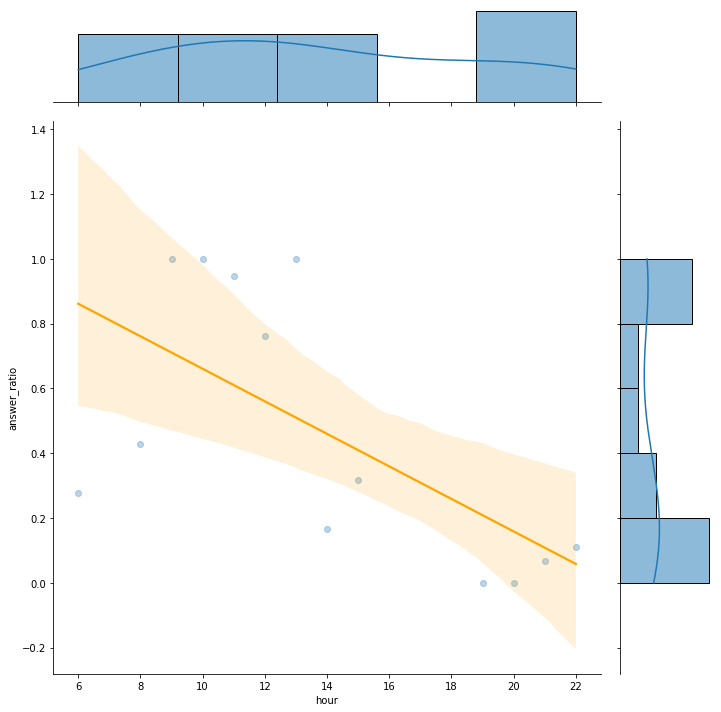

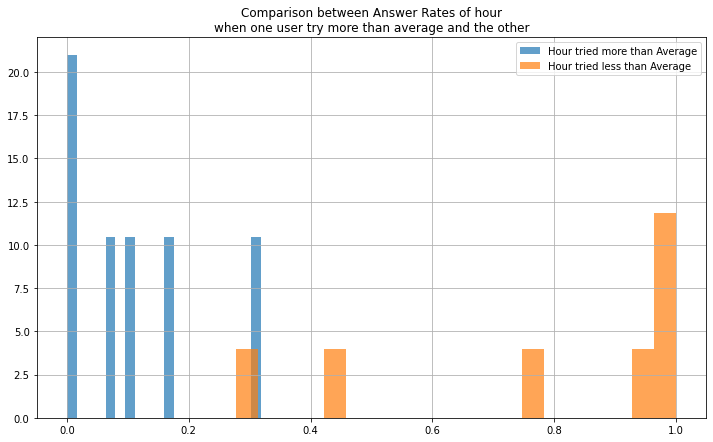

In [35]:
plot_random_user_hour()

추가로 할 것.
* user가 시간에 따른 정답률에 상관관계가 있다. 하지만, 이것이 특정 시간에 문제를 많이 풀어서 그런 것인지 확인해봐야 겠다.
* 0 - 24 대신 6 - 다음날 6으로 할까??

# 3. 푼 문항의 개수

In [36]:
# 누적합: 정답을 맞춘 횟수를 누적함.
_cumsum = train_df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수: 시도한 횟수를 누적함.
_cumcount = train_df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = train_df['userID'] # 문제를 시도한 횟수에 따른 정답 률
window_sizes = [30, 70, 100, 120]

In [37]:
user_nums = train_df['userID'].nunique()

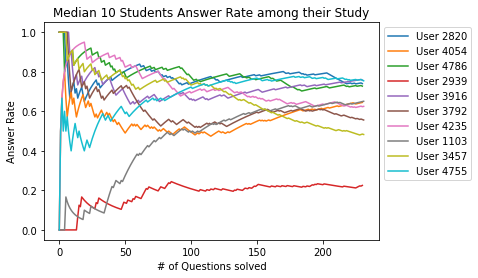

In [38]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Students Answer Rate among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

# 푼 문항의 갯수가 중앙값 부근인 10명의 학생들
# 총 학생 6698명...? why 7442??
samples = train_df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID').index[user_nums//2-5:user_nums//2+5]

for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

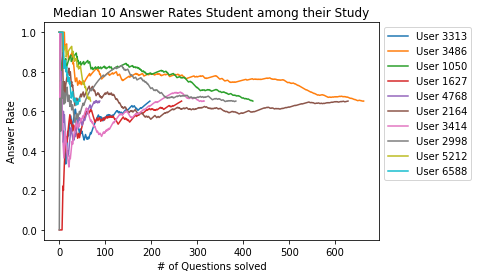

In [39]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

# 정답률이 중앙값 부근인 10명의 학생들
samples = train_df.groupby('userID').agg({'answerCode': percentile}).sort_values(by='answerCode').index[user_nums//2-5:user_nums//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

User가 문제를 풀어감에 따라 변하는 평균 정답 수

Window size로 정답률을 구할 문제의 크기를 정함.

In [40]:
def plot_rolled_answerrate(df, userID, ax, window_sizes=[70, 100, 120]):
    
    ax.set_title(f'Students Answer Rate among their Study - User {userID}')
    ax.set_xlabel('# of Questions solved')
    ax.set_ylabel('Answer Rate')

    cum_ans[cum_ans['userID'] == userID]['answerCode'].reset_index(drop=True).plot(
        ax=ax, label=f'Without Window', linewidth=3)

    for wdw_sz in window_sizes:    
        df[df.userID == userID]['answerCode'].rolling(wdw_sz).mean().reset_index(drop=True).plot(
            ax=ax, label=f'Window size {wdw_sz}', alpha=0.8)

    ax.legend()

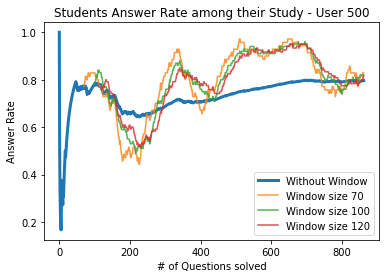

In [41]:
fig, ax = plt.subplots()
plot_rolled_answerrate(train_df, 500, ax)

정답을 맞춘 수로 정렬을 해서 상위 9명을 뽑아 window size를 바꿔가며 plot한다.

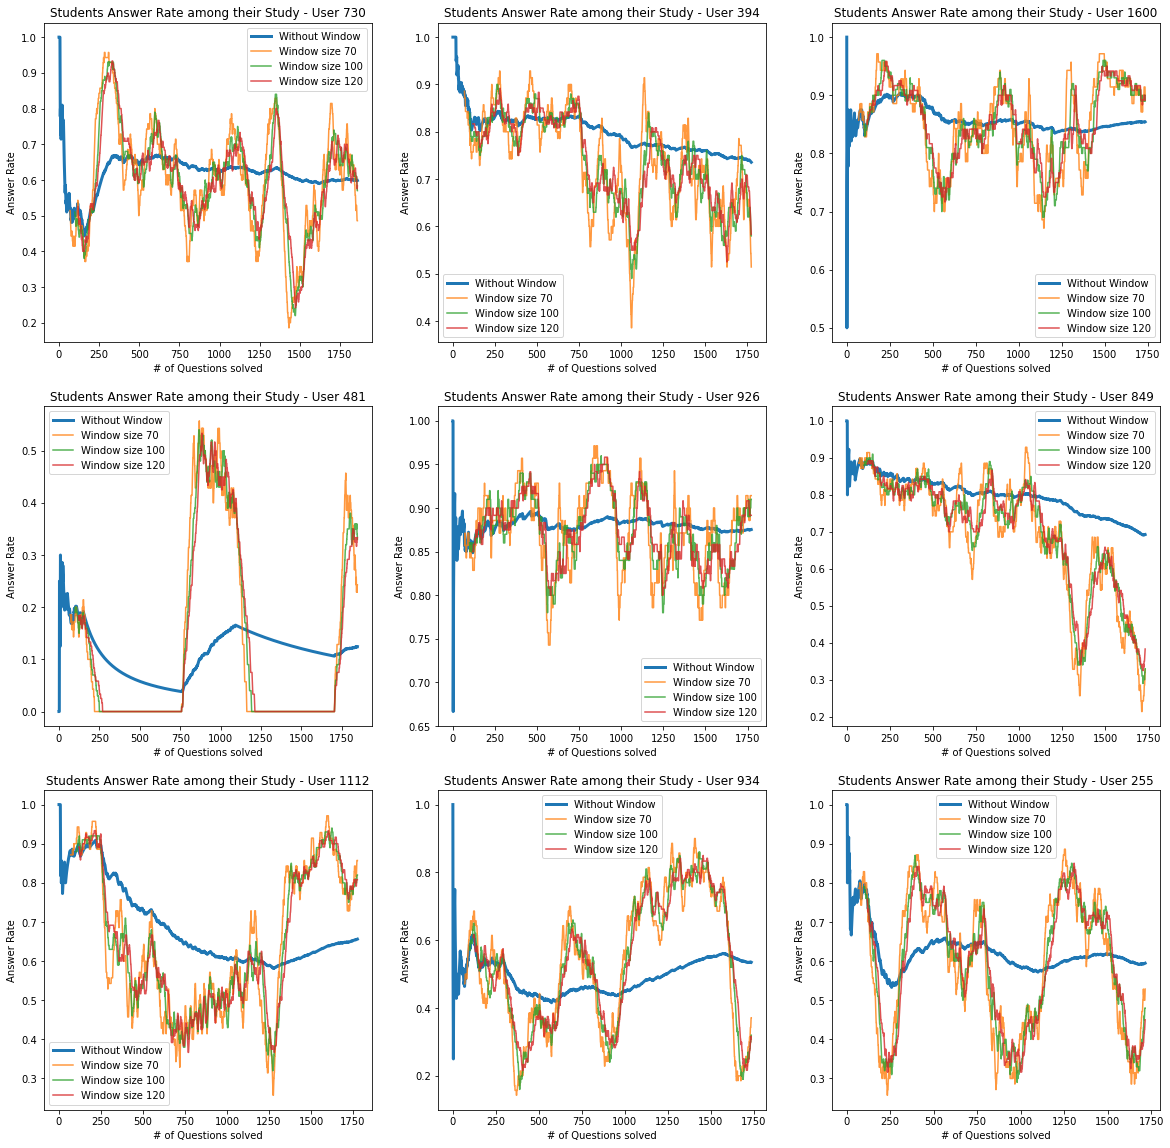

In [42]:
idx = train_df.groupby('userID').agg({'answerCode': 'count'}).sort_values(by='answerCode', ascending=False).iloc[:9].index
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
plt.title('Top 9 Students who solved the most problems')
for i, userID in enumerate(idx):
    r, c = i%3, i//3
    plot_rolled_answerrate(train_df, userID, axes[r, c])

결과를 보면 문제를 많이 맞춘 것과 정답률 사이의 상관관계는 별로 없는 것 같다.

그러면 같은 문항수를 푼 학생들의 평균을 그려보자.

In [56]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,6632178.0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0


In [57]:
# userID를 기준으로 문제를 푼 assessmentItemID의 수와 user의 평균 정답률을 구한다.
stu_groupby = train_df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


In [59]:
# 같은 문항 수를 푼 user들의 평균을 구한다.
itemnum_ans = stu_groupby.groupby('assessmentItemID').mean()
itemnum_ans['num_items'] = itemnum_ans.index

Text(0, 0.5, 'Answer Rate')

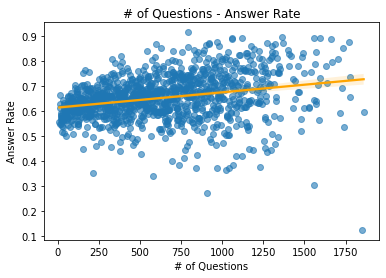

In [61]:
fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='num_items', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha':0.6}, ax=ax)

ax.set_title('# of Questions - Answer Rate')
ax.set_xlabel('# of Questions')
ax.set_ylabel('Answer Rate')

그런데 위 그래프도 점이 너무 많다. 

이것보다 더 줄이려면 단순히 같은 문항수를 푼 학생들끼리 평균을 집계하는 것이 아니라, 어느 정도 비슷한 문항을 푼 학생들을 전부 집계하면 좋을 것 같다. 
예를 들면 9 ~ 14문항을 푼 학생들을 묶어서 평균을 내자.

`bins` 값을 주었을 때 bins 만큼 그래프에 점이 찍히도록, 예를 들어 bins=500이었다면 아래와 같이 500개의 bin을 만들도록 그래프를 그리자.

In [89]:
bins=300
itemnum_ans['bins'] = pd.cut(
    itemnum_ans.index,
    # index를 bins 개수만큼 나눈다.
    # 총 300개의 구간이 나온다.
    # [i * (itemnum_ans.index.max() - itemnum_ans.index.min()) // bins for i in range(bins)]
    [i * itemnum_ans.index.max() // bins for i in range(1, bins+1)]
)

In [91]:
# bins를 기준으로 즉 유사한 문항수 기준으로, 정답률과 문항수의 평균을 구한다.
itemnum_ans = itemnum_ans.groupby('bins').mean()
itemnum_ans['mid'] = list(map(lambda x: (x.left + x.right)//2, itemnum_ans.index))

1847 문항을 푼 사람들의 정답률 평균이 왜 이렇게 낮을까?

Text(0, 0.5, 'Answer Rate')

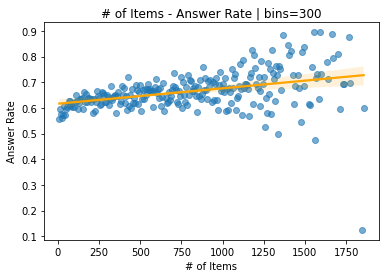

In [93]:
fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='mid', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)

ax.set_title(f'# of Items - Answer Rate | bins={bins}')
ax.set_xlabel('# of Items')
ax.set_ylabel('Answer Rate')

# 문항을 푸는 데 걸린 시간과 정답률 사이의 관계는?

In [47]:
diff = train_df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

train_df['elapsed'] = diff

# elapsed_answer 기준으로 answerCode에는 정답률, userID에는 해당 user의 수를 표현한다.
elapsed_answer = train_df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
# user의 수가 100명이 넘는 elapsed만 뽑는다.
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

(-10.0, 650.0)

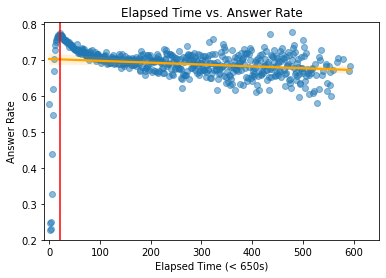

In [55]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index, y=elapsed_hist.answerCode.values,
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')
ax.set_xlim(-10, 650)